## 생성 모델

- 주어진 데이터를 학습하여 **데이터 분포**를 따르는 유사한 데이터를 생성하는 모델

- 판별자 : 대상의 **특징**들을 찾아내서 이미지를 분류할 수 있도록 함

  - ex) 강아지/고양이 분류를 위해 눈, 꼬리 등의 특성을 파악함
<br><br>
- 생성자 : 판별자에서 추출한 특징을 이용하여 새로운 이미지를 생성하도록 함

  - 입력 이미지에 대한 **데이터 분포**를 학습하여, 입력 이미지와 유사한 이미지를 생성하도록 함

- 명시적 방법

  - 모델의 확률 변수 p(x)를 **정의**하여 사용함

  - ex) VAE(Variational AutoEncoder)
<br><br>
- 암시적 방법

  - 확률 변수에 대한 정의 없이 p(x)를 **샘플링**하여 사용함
  
  - ex) GAN(Generative Adversarial Network)

---

## 변형 오토인코더

#### AutoEncoder

- AutoEncoder의 은닉층의 뉴런 수는 입력층과 출력층의 뉴런 수보다 훨씬 적음
  
  -> 은닉층의 **적은 뉴런**으로도 데이터를 가장 잘 표현할 수 있게 하는 방법

- 인코더 : `특성`에 대한 학습을 수행함 (recognition network)

- 은닉층 : 차원이 가장 낮은, 입력 데이터의 `압축된 표현`이 만들어짐

- 디코더 : 압축된 데이터를 원래대로 `복원`함 (generative network)

- 손실 재구성 : 손실함수는 {입력값}과 {복원된 출력값}의 차이로 계산됨

<img src="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-06-at-3.17.13-PM.png" width="500px">

- 입력 x를 인코더 h에 통과시켜, 압축된 잠재 벡터 z를 얻음

  - z = h(x)
<br><br>
- 압축된 z 벡터를 디코더 g에 통과시켜, 출력 y를 얻음

  - y = g(z) = g(h(x))
<br><br>
- 이 때, 출력 y는 입력 x와 크기가 같아야 함
<br><br>
- 손실함수 값은 입력 x와 출력 y의 차이로 계산됨

<img src="https://thebook.io/img/080289/685.jpg" width="500px">

- 데이터 압축 : 데이터의 중요 특성만 압축하여 메모리 측면에서 이점을 얻음
<br><br>
- 차원의 저주 방지 : 특성의 개수를 줄여주어(데이터 차원을 감소시켜) 차원의 저주를 피할 수 있음
<br><br>
- 특성 추출 : 비지도 학습으로, 주요 특성을 자동으로 찾아줌

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

In [2]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()

        # Convolution 연산으로 이미지 특성 추출 (차원 축소)
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(inplace=True)
        )

        self.flatten = nn.Flatten(start_dim=1)

        # 잠재벡터 생성
        self.encoder_lin = nn.Sequential(
            nn.Linear(3*3*32, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, encoded_space_dim)
        )


    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

In [3]:
class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()

        # 인코더의 출력을 디코더의 입력으로 사용
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 3*3*32),
            nn.ReLU(inplace=True)
        )


        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        # 이미지 복원
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True)
        )


    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [4]:
encoder = Encoder(encoded_space_dim=4, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=4, fc2_input_dim=128)

In [5]:
encoder

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [6]:
decoder

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_cnn): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): ReLU(inplace=True)
  )
)

In [8]:
summary(encoder.to(torch.device('cuda')), input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 14, 14]              80
              ReLU-2            [-1, 8, 14, 14]               0
            Conv2d-3             [-1, 16, 7, 7]           1,168
       BatchNorm2d-4             [-1, 16, 7, 7]              32
              ReLU-5             [-1, 16, 7, 7]               0
            Conv2d-6             [-1, 32, 3, 3]           4,640
              ReLU-7             [-1, 32, 3, 3]               0
           Flatten-8                  [-1, 288]               0
            Linear-9                  [-1, 128]          36,992
             ReLU-10                  [-1, 128]               0
           Linear-11                    [-1, 4]             516
Total params: 43,428
Trainable params: 43,428
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

#### Variational AutoEncoder

- 일반적인 AutoEncoder

  - 입력 -> 인코더 -> 압축 -> 디코더 -> 출력

  - 차원을 축소하고 `입력과 동일한 데이터`를 만드는 것이 목표
  
    - 새로 생성된 데이터의 확률 분포에는 관심 없음

- Variational AutoEncoder

  - 평균과 표준편차를 이용하여 `확률 분포`를 만듦

  - 여기서 샘플링하여 디코더를 통과시킨 후, `입력과 조금 다른 데이터`를 만들어냄
  
  - 데이터가 만들어지는 확률 분포를 찾아 유사한 데이터를 생성하는 것이 목표

<img src="https://vitalflux.com/wp-content/uploads/2023/04/autoencoder-vs-variational-autoencoder-point-vs-distribution.png" width="350px">

##### Encoder

- 데이터 x가 주어졌을 때, 디코더가 잘 복원할 수 있는 **이상적인 확률 분포 p(z|x)** 찾는 것이 목표

- 이상적인 확률 분포 찾는 데는 **변분추론(variational inference)** 사용

  - `가우시안 분포`를 가정하고 모수를 바꿔가며, 이상적 확률 분포에 근사하게 만들어 사용하는 것

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.input1 = nn.Linear(input_dim, hidden_dim)
        self.input2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True


    def forward(self, x):
        h_ = self.LeakyReLU(self.input1(x))
        h_ = self.LeakyReLU(self.input2(h_))
        mean = self.mean(h_)
        log_var = self.var(h_)
        return mean, log_var # 평균, 분산을 반환

##### Decoder

- 추출한 샘플을 입력받아 원본으로 **복원**하는 것이 목표

In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)


    def foward(self, x):
        h = self.LeakyReLU(self.hidden1(x))
        h = self.LeakyReLU(self.hidden2(h))
        x_hat = torch.sigmoid(self.output(h))
        return x_hat

##### VAE

In [11]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    # 잠재변수 z 샘플링 함수
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)
        z = mean + var * epsilon
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x) # 인코더에서 평균, 표준편차를 받아옴
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # 평균, 표준편차를 이용해 z를 생성함 (z는 가우시안 분포로 가정했기 때문에)
        x_hat = self.Decoder(z) # z를 디코더에 통과시켜, 입력 x와 유사한 x^ 생성함
        return x_hat, mean, log_var

In [12]:
x_dim = 784
hidden_dim = 400
latent_dim = 200

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

model = Model(Encoder=encoder, Decoder=decoder)

In [13]:
model

Model(
  (Encoder): Encoder(
    (input1): Linear(in_features=784, out_features=400, bias=True)
    (input2): Linear(in_features=400, out_features=400, bias=True)
    (mean): Linear(in_features=400, out_features=200, bias=True)
    (var): Linear(in_features=400, out_features=200, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (Decoder): Decoder(
    (hidden1): Linear(in_features=200, out_features=400, bias=True)
    (hidden2): Linear(in_features=400, out_features=400, bias=True)
    (output): Linear(in_features=400, out_features=784, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

---

## 적대적 생성 신경망

#### GAN

- 생성자와 판별자의 적대적 학습
  - 판별자
    - (1) 실제 이미지를 입력하여 '진짜'로 분류하도록 학습시킴
    - (2) 생성자가 생성한 모조 이미지를 입력하여 '가짜'로 분류하도록 학습시킴
  - 생성자
    - 진짜 이미지와 유사한 모조 이미지를 생성하도록 학습시킴
  - 생성자는 더욱 진짜같은 이미지를 생성하고, 판별자는 더욱 정확히 분류하도록 하여, 경쟁적으로 발전시키는 구조


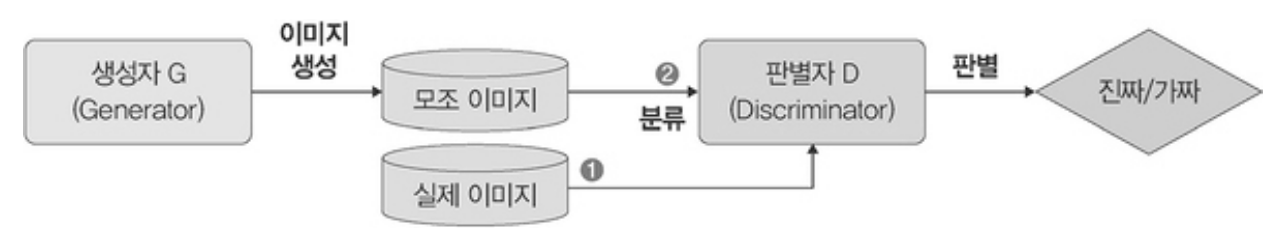

### 동작 원리

- 판별자 : 어떤 이미지 x가 주어졌을 때, 판별자 D는 진짜 이미지일 확률 D(x)를 반환함
- 생성자 : 임의의 노이즈로부터, 생성자 G는 모조 이미지 G(*)를 생성함

  -> 생성자가 만든 모조 이미지 G(z)를 판별자의 입력으로 주면, 모조 이미지가 실제 이미지일 확률 D(G(z))를 반환함

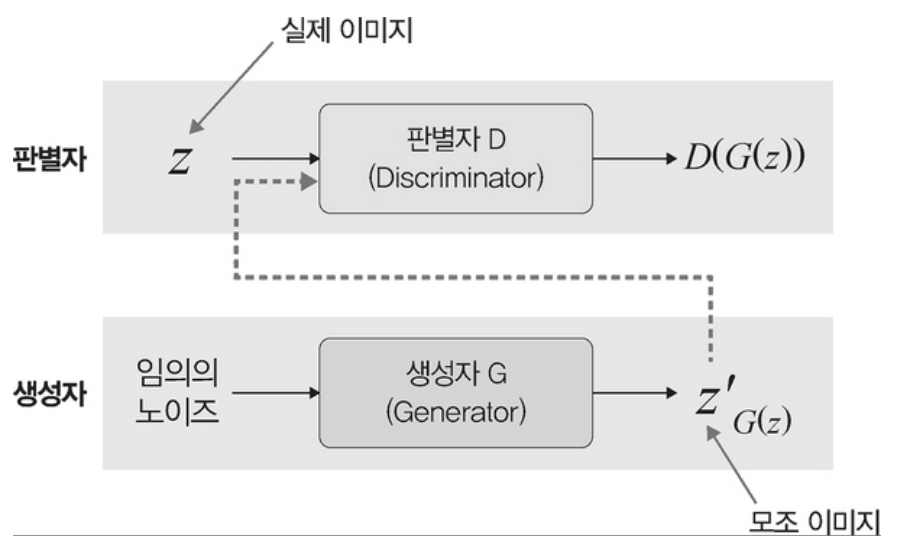

### 손실함수

#### GAN 손실함수

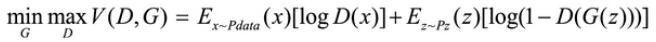

- x~Pdata(x) : **실제 데이터**에 대한 확률 분포에서 샘플링한 데이터
- z~Pz(z) : **임의의 노이즈**에서 샘플링한 데이터
- D(x) : 판별자 D(x)가, 1에 가까우면 진짜 데이터로 판단 / 0에 가까우면 가짜 데이터로 판단
- D(G(z)) : 생성된 이미지 G(z)가, 1에 가까우면 진짜 데이터로 판단 / 0에 가까우면 가짜 데이터로 판단

- 판별자 D
  - 실제 이미지 x를 입력 받을 경우, D(x)를 1로 예측함
  - 모조 이미지 G(z)를 입력 받을 경우, D(G(z))를 0으로 예측함
    
    -> 따라서, 판별자가 모조 이미지를 입력 받았을 때, 1로 예측하도록 하는 것이 최종 목표임

#### 판별자 손실함수

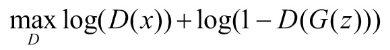

- 최상의 결과 :
  - D(x) = 1 : 실제 이미지를 '진짜'로 분류
  - D(G(z)) = 0 : 모조 이미지를 '가짜'로 분류

- 위 식을 최대로 하는 방향으로 업데이트하여, 판별 능력을 키움

#### 생성자 손실함수

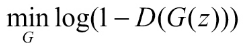

- 최상의 결과 :
  - D(G(z)) = 1 : 모조 이미지를 '진짜'로 분류

- 위 식을 최소로 하는 방향으로 업데이트하여, 진짜 같은 이미지 생성 능력을 키움

### 구현

#### 라이브러리

In [14]:
import imageio
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms

#### 변수 설정

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [49]:
batch_size = 512
epochs = 20
sample_size = 64
nz = 128
k = 1

#### MNIST 이미지 데이터 다운로드

In [50]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, )),
])

train_dataset = datasets.MNIST(
    root="/content/data", train=True, transform=transform, download=True
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### 모델 생성

In [51]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()

        self.nz = nz # 잠재벡터 크기

        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )


    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28) # 생성자의 최종 반환값 : (batch_size x 1 x 28 x 28)

In [52]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.n_input = 784

        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )


    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x) # 진짜 이미지일 확률 반환

In [53]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

In [54]:
generator

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [55]:
discriminator

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

#### 파라미터 설정

In [56]:
optim_generator = optim.Adam(generator.parameters(), lr=0.0002)
optim_discriminator = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_generator = [] # 생성자의 손실함수값
losses_discriminator = [] # 판별자의 손실함수값
images = [] # 생성되는 이미지

In [57]:
def save_generator_image(image, path):
    save_image(image, path)

#### 모델 학습

In [58]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0) # batch_size 정보

    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)

    optimizer.zero_grad()

    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)

    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)

    loss_real.backward()
    loss_fake.backward()

    optimizer.step()

    return loss_real + loss_fake

In [59]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)

    real_label = torch.ones(b_size, 1).to(device)

    optimizer.zero_grad()

    output = discriminator(data_fake)
    loss = criterion(output, real_label)

    loss.backward()

    optimizer.step()

    return loss

In [60]:
import os

os.mkdir('/content/img')

FileExistsError: ignored

In [61]:
generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_generator = 0.0
    loss_discriminator = 0.0

    for idx, data in tqdm(enumerate(train_loader), total=int(len(train_dataset)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)

        for step in range(k):
            data_fake = generator(torch.randn(b_size, nz).to(device)).detach()
            data_real = image
            loss_discriminator += train_discriminator(optim_generator, data_real, data_fake)

        data_fake = generator(torch.randn(b_size, nz).to(device))
        loss_generator += train_generator(optim_generator, data_fake)

    generated_img = generator(torch.randn(b_size, nz).to(device)).cpu().detach()
    generate_img = make_grid(generated_img)

    save_generator_image(generated_img, f"/content/img/gen_img{epoch}.png")
    images.append(generated_img)

    epoch_loss_generator = loss_generator / idx
    epoch_loss_discriminator = loss_discriminator / idx

    losses_generator.append(epoch_loss_generator)
    losses_discriminator.append(epoch_loss_discriminator)

    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator Loss: {epoch_loss_generator:.8f}, Discriminator Loss: {epoch_loss_discriminator:.8f}")

118it [00:12,  9.37it/s]                         


Epoch 0 of 20
Generator Loss: 0.42572817, Discriminator Loss: 1.78308558


118it [00:12,  9.32it/s]


Epoch 1 of 20
Generator Loss: 0.38395318, Discriminator Loss: 1.85356152


118it [00:12,  9.37it/s]                         


Epoch 2 of 20
Generator Loss: 0.38208690, Discriminator Loss: 1.85841918


118it [00:12,  9.28it/s]                         


Epoch 3 of 20
Generator Loss: 0.38066298, Discriminator Loss: 1.86037493


118it [00:12,  9.39it/s]                         

Epoch 4 of 20
Generator Loss: 0.38060576, Discriminator Loss: 1.86173487



118it [00:12,  9.29it/s]                         

Epoch 5 of 20
Generator Loss: 0.37969840, Discriminator Loss: 1.86402011



118it [00:12,  9.24it/s]                         

Epoch 6 of 20
Generator Loss: 0.37934762, Discriminator Loss: 1.86445272



118it [00:12,  9.16it/s]                         


Epoch 7 of 20
Generator Loss: 0.37877661, Discriminator Loss: 1.86549592


118it [00:12,  9.61it/s]                         

Epoch 8 of 20
Generator Loss: 0.37860760, Discriminator Loss: 1.86617434



118it [00:11,  9.86it/s]                         

Epoch 9 of 20
Generator Loss: 0.37796250, Discriminator Loss: 1.86715662



118it [00:12,  9.81it/s]                         

Epoch 10 of 20
Generator Loss: 0.37714830, Discriminator Loss: 1.86869144



118it [00:12,  9.74it/s]                         

Epoch 11 of 20
Generator Loss: 0.37664497, Discriminator Loss: 1.87051618



118it [00:12,  9.69it/s]                         

Epoch 12 of 20
Generator Loss: 0.37603304, Discriminator Loss: 1.87152052



118it [00:12,  9.81it/s]                         


Epoch 13 of 20
Generator Loss: 0.37458494, Discriminator Loss: 1.87504220


118it [00:11,  9.87it/s]                         

Epoch 14 of 20
Generator Loss: 0.37375063, Discriminator Loss: 1.87650728



118it [00:11,  9.87it/s]                         

Epoch 15 of 20
Generator Loss: 0.37334466, Discriminator Loss: 1.87760532



118it [00:11, 10.25it/s]                         

Epoch 16 of 20
Generator Loss: 0.37294388, Discriminator Loss: 1.87899828



118it [00:11, 10.31it/s]                         

Epoch 17 of 20
Generator Loss: 0.37246937, Discriminator Loss: 1.87965000



118it [00:11, 10.16it/s]                         

Epoch 18 of 20
Generator Loss: 0.37249854, Discriminator Loss: 1.88050044



118it [00:11, 10.16it/s]                         

Epoch 19 of 20
Generator Loss: 0.37224826, Discriminator Loss: 1.88008535


#### 생성자와 판별자의 오차 확인

- 생성자의 오차가 감소하면 판별자의 오차는 증가함

- 생성자
  - 점점 진짜와 같은 가짜 이미지를 만들어냄

- 판별자
  - 점점 가짜 이미지를 진짜라고 잘못 분류함

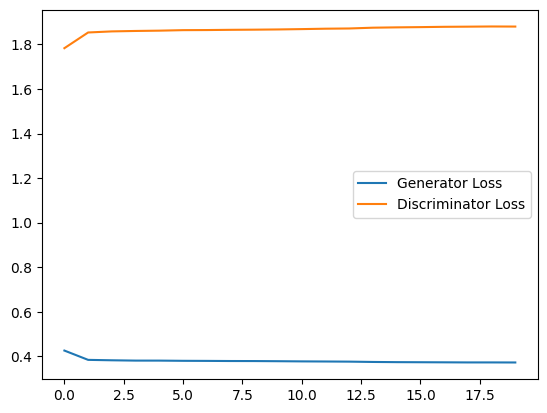

In [62]:
plt.figure()

losses_generator = [f1.item() for f1 in losses_generator]
plt.plot(losses_generator, label='Generator Loss')

losses_discriminator = [f2.item() for f2 in losses_discriminator]
plt.plot(losses_discriminator, label='Discriminator Loss')

plt.legend()

#### 생성된 이미지 확인

In [ ]:
fake_images = generator(torch.randn(b_size, nz).to(device))
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28, 28))
    plt.imshow(fake_images_img, cmap='grey')
    plt.save('/content/img/fake_images_img' + str(i) + '.png')
    plt.show()

# 13.4 GAN 파생 기술

GAN은 생성자와 판별자 중 한쪽으로 치우친 학습이 발생하면, 성능에 문제가 생길 수 있음
  
  -> 정상적인 분류 불가능

### DCGAN

- GAN 학습에 CNN을 사용한 모델

- 특징
  - Pooling을 모두 없애고, **Strided Convolution** 연산을 사용함
  - Batch Normalization을 통해 안정적으로 gradient를 계산하도록 함

#### Strided Convolution

- 판별자 네트워크에서 사용
  - 이미지 특성을 추출하는 연산이 필요하기 때문

- 합성곱 연산에서 **1 이상의 정수 값** stride를 부여함
- 출력 feature map의 크기를 **줄이는 것**

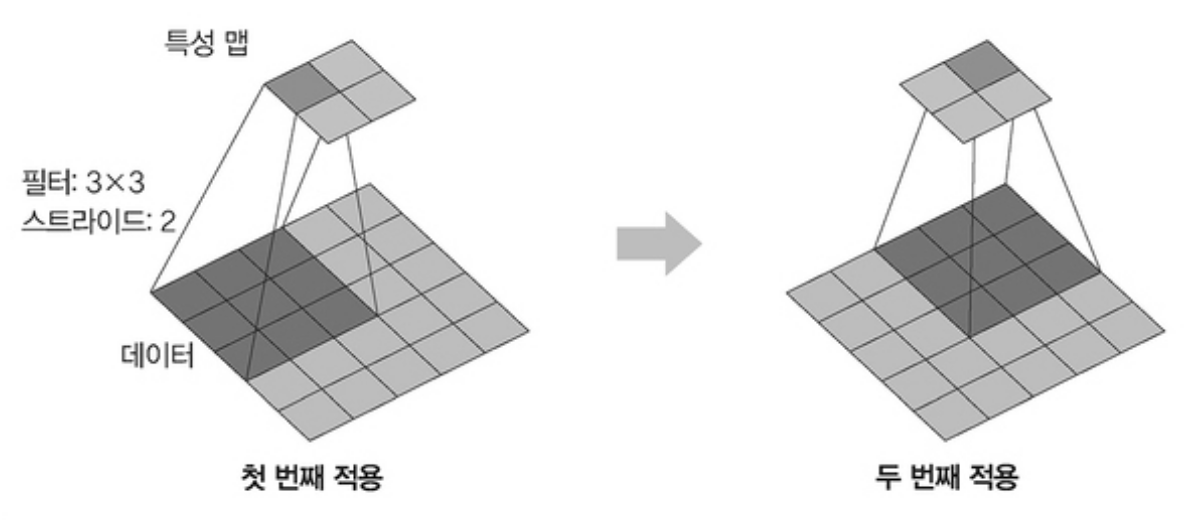

#### Fractional-Strided Convolution

- 생성자 네트워크에서 사용
  - 노이즈를 입력받아 실제 이미지와 같은 해상도로 크기를 키워야 하기 때문

- 합성곱 연산에서 **1보다 작은 분수 값** stride를 부여함
- 출력 feature map의 크기를 **키우는 것**

- ex) 2x2 feature map
  - 4개의 각 픽셀 주위에 zero-padding을 넣어줌
  - 그렇게 부풀려진 feature map에 Convolution 연산을 수행함
  - 더 큰 feature map을 얻음

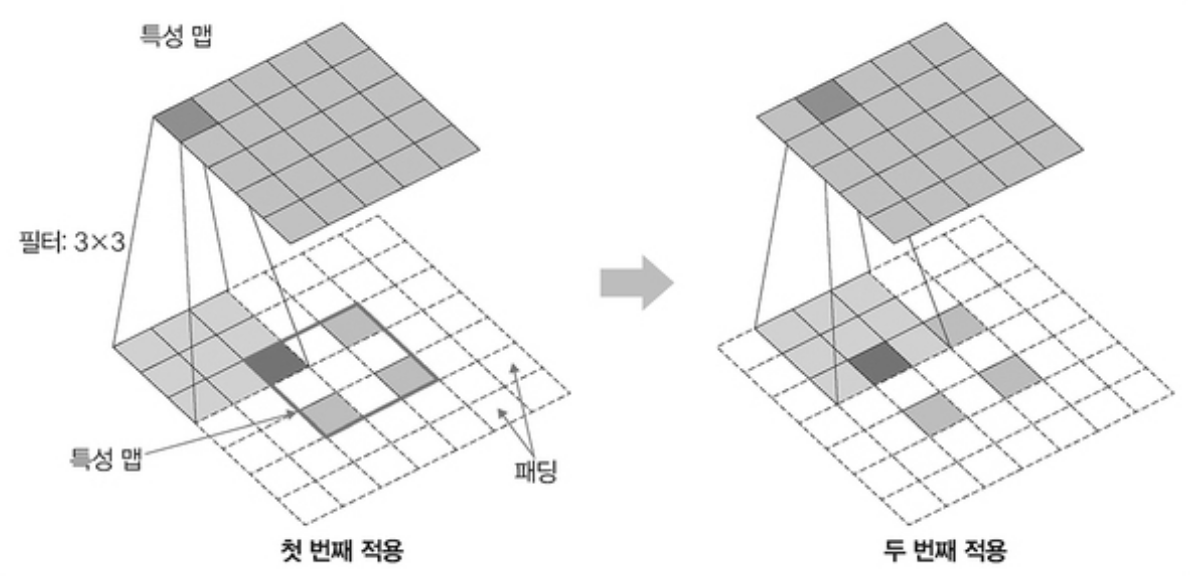

### cGAN

- GAN의 출력에 조건을 주어 이미지 생성을 통제할 수 있도록 하는 모델

- 특징
  - 생성자에 노이즈 벡터와 조건 벡터 C를 함께 입력함
  - 판별자에도 마찬가지로 C가 추가됨
    
    -> 기존 이미지에서 **변형된** 이미지 생성이 가능해짐

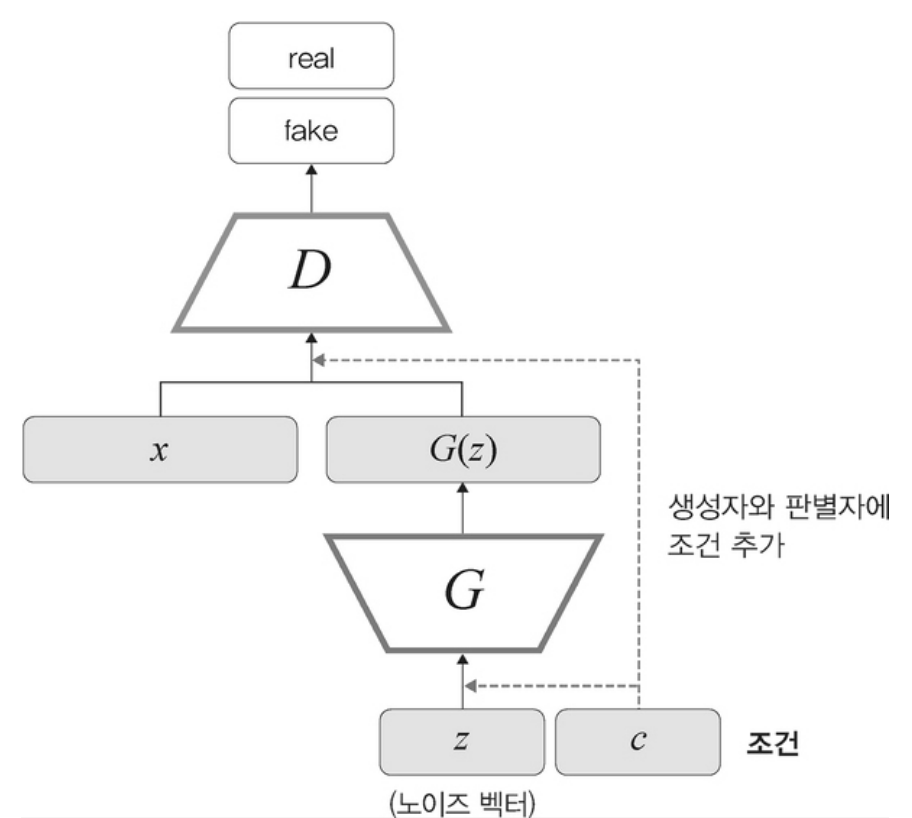

### CycleGAN

- 이미지가 주어졌을 때 다른 이미지로 변형시키는 모델

- GAN, DCGAN은 랜덤 노이즈를 입력으로 하여 무작위 데이터가 생성되므로, 원하는 결과를 얻기 어려움
  
  -> 이를 해결하는 방법이 PIX2PIX

#### PIX2PIX

- 임의의 노이즈 벡터가 아닌 **이미지**를 입력 받음
- 다른 스타일의 이미지를 출력하는 **지도 학습** 알고리즘

- 특징
  - 인코더 - 디코더 구조
    - 인코더 : 입력 데이터의 특징 추출
    - 디코더 : 이미지 생성

  - 생성자는 **진짜 같은 가짜 이미지**를 만들어야 하며, 또한 **정답 이미지와 같아야** 함

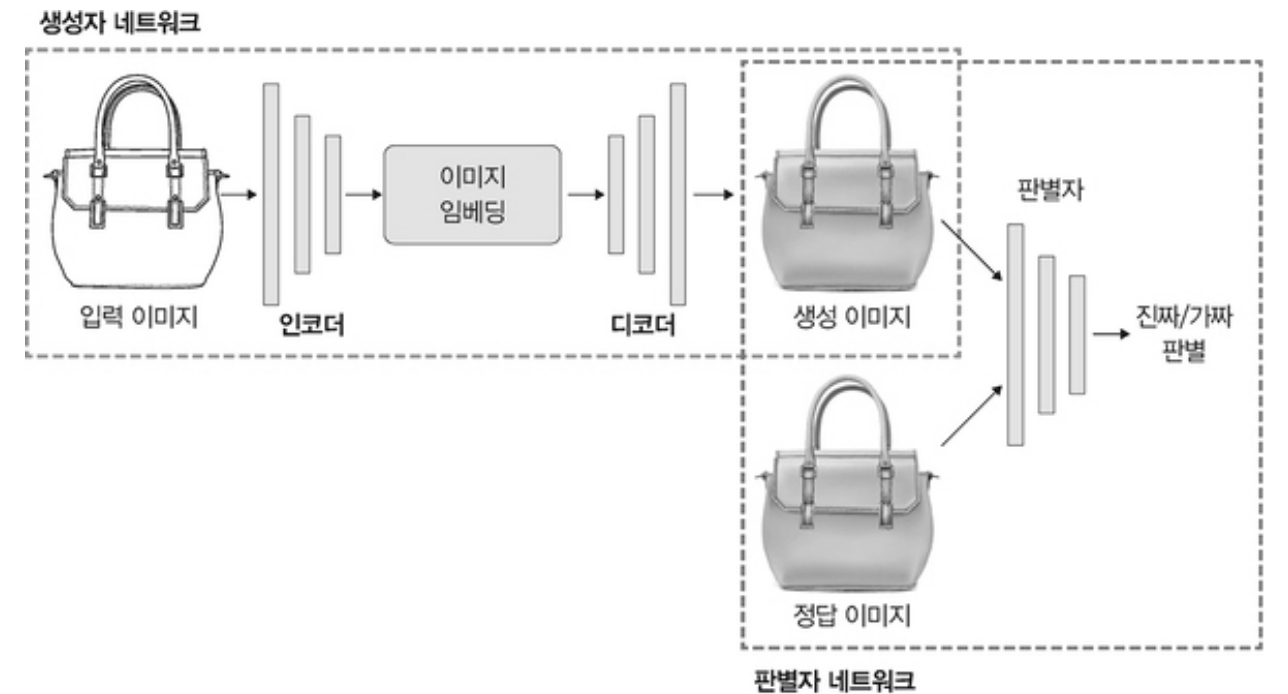

- 데이터 쌍이 필요하다는 단점 존재
  - ex) 흑백 이미지 -> 컬러 이미지 변환
    
    -> 쌍을 이루는 이미지 데이터를 얻기 어려움

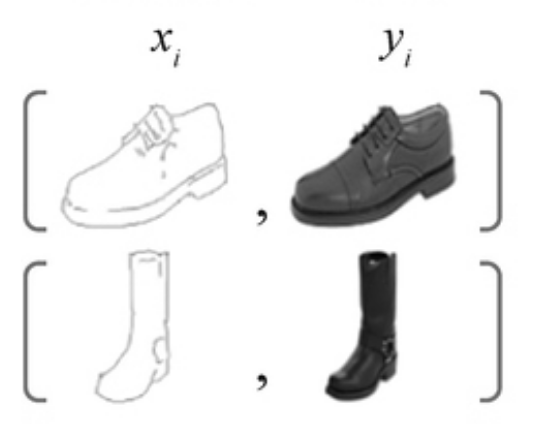

#### CycleGAN

- 두 개의 생성자를 가짐
  - G : 이미지 X를 이미지 Y로 변환함
  - F : 이미지 Y를 다시 이미지 X로 변환함

  - Dx : 이미지 X를 위한 판별자
  - Dy : 이미지 Y를 위한 판별자

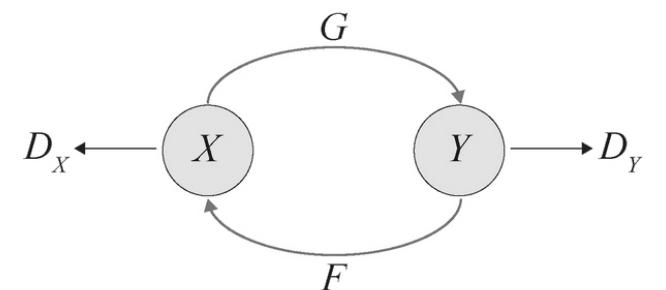

- ex) 조랑말 이미지를 얼룩말 이미지로 변환
  - 생성자 G : 조랑말 X -> 얼룩말 Y^
  - 생성자 F : 얼룩말 Y^ -> 조랑말 X^

  - 조랑말 X가 조랑말 X^과 얼마나 가까운 지 손실함수를 사용하여 계산함

- 순환 일관성 : X -> Y^, Y^ -> X^ 로 연결되는 것

- 정방향 일관성 : X -> Y^

- 역방향 일관성 : Y^ -> X^

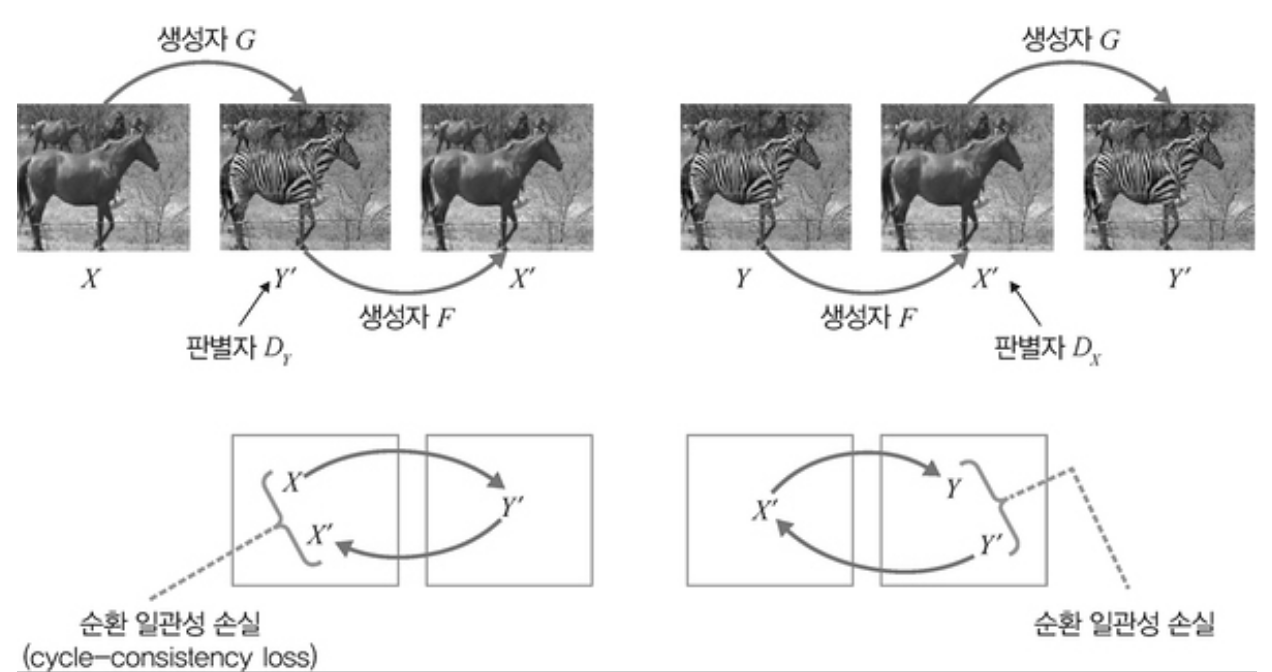

---